<a href="https://colab.research.google.com/github/jsedoc/ConceptorDebias/blob/master/ConceptorPostPro_DEMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q gensim

In [0]:
from numpy import dot, trace
import math
import random 
import scipy.io as sio
from scipy.stats import spearmanr
from sklearn.metrics.pairwise import cosine_similarity
from numpy.linalg import norm, inv, eig
from matplotlib.pyplot import plot
import numpy as np
import matplotlib.pyplot as plt
import numpy.matlib

import gensim

from gensim.models.keyedvectors import KeyedVectors


# Load word embeddings GloVe and Word2Vec (takes ~2 min on my laptop)

In [0]:
!pip install -q gdown

In [0]:
!gdown https://drive.google.com/uc?id=1Ty2exMyi-XOufY-v81RJfiPvnintHuy2

Downloading...
From: https://drive.google.com/uc?id=1Ty2exMyi-XOufY-v81RJfiPvnintHuy2
To: /content/gensim_glove.840B.300d.txt.bin
2.65GB [00:22, 117MB/s]


In [0]:
!gdown https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM

Downloading...
From: https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM
To: /content/GoogleNews-vectors-negative300.bin.gz
1.65GB [00:10, 151MB/s]


In [0]:


#resourceFile = '/Users/liutianlin/Desktop/Academics/NLP/data/'
resourceFile = '/content/'


glove = KeyedVectors.load_word2vec_format(resourceFile + 'gensim_glove.840B.300d.txt.bin', binary=True)
print('The glove embedding has been loaded!')


word2vec = KeyedVectors.load_word2vec_format(resourceFile + 'GoogleNews-vectors-negative300.bin.gz', binary=True)
print('The Google News Word2Vec embedding has been loaded!')


The glove embedding has been loaded!
The Google News Word2Vec embedding has been loaded!


# Load the words that appear at least 200 times in wikipedia


In [0]:
!git clone https://github.com/PrincetonML/SIF

Cloning into 'SIF'...
remote: Enumerating objects: 128, done.
remote: Total 128 (delta 0), reused 0 (delta 0), pack-reused 128
Receiving objects: 100% (128/128), 2.80 MiB | 18.13 MiB/s, done.
Resolving deltas: 100% (56/56), done.


In [0]:
wikiWordsPath = resourceFile + '/SIF/auxiliary_data/enwiki_vocab_min200.txt' # https://github.com/PrincetonML/SIF/blob/master/auxiliary_data/enwiki_vocab_min200.txt
wikiWords = []
with open(wikiWordsPath, "r+") as f_in:
    for line in f_in:
        wikiWords.append(line.split(' ')[0])   


#Training An Autoencoder

In [0]:
from __future__ import division, print_function, absolute_import

import tensorflow as tf


In [0]:
wordVecModel = eval('word2vec')    
word_in_wiki_and_model = set(list(wordVecModel.vocab)).intersection(set(wikiWords))

x_collector_indices = []
x_collector_column_weights = []


for word in word_in_wiki_and_model:
    x_collector_indices.append(wordVecModel.vocab[word].index)

# put the word vectors in columns
x_collector = wordVecModel.vectors[x_collector_indices,:]    
nrWords = x_collector.shape[0] # number of total words


In [0]:
x_standarized = (x_collector - np.mean(x_collector,0))/np.std(x_collector,0)

In [0]:
np.max(x_standarized)

10.634587

In [0]:
np.min(x_standarized)

-7.9402432

In [0]:
nrWords

76078

In [0]:
def make_tf_data_batch(np_data,nr, batch_size, shuffle=True ):  
  
  # Create the TF dataset.   
  dataset = tf.data.Dataset.from_tensor_slices(np_data)
  
  if shuffle:
    dataset = dataset.shuffle(nr).repeat()
    
  # Batch the data and return the data batch.
  one_shot_iterator = dataset.batch(batch_size).make_one_shot_iterator()
  data_batch = one_shot_iterator.get_next()
  return data_batch

In [0]:
# Training Parameters
learning_rate = 0.001
num_steps = 30000
batch_size = 128


real_data = make_tf_data_batch(x_standarized,nrWords,batch_size)
print(real_data.shape)


(?, 300)


In [0]:
# Network Parameters
num_hidden_1 = 300 # 1st layer num features
num_hidden_2 = 500 # 2nd layer num features (the latent dim)
num_input = 300 # data input 

Drop = tf.placeholder("float", [None, num_hidden_2])

weights = {
    'encoder_h1': tf.Variable(tf.truncated_normal([num_input, num_hidden_1], stddev=0.1)),
    'encoder_h2': tf.Variable(tf.truncated_normal([num_hidden_1, num_hidden_2], stddev=0.1)),
    'decoder_h1': tf.Variable(tf.truncated_normal([num_hidden_2, num_hidden_1], stddev=0.1)),
    'decoder_h2': tf.Variable(tf.truncated_normal([num_hidden_1, num_input], stddev=0.1)),
}
biases = {
    'encoder_b1': tf.Variable(tf.constant(0.1, shape=[num_hidden_1])),
    'encoder_b2': tf.Variable(tf.constant(0.1, shape=[num_hidden_2])),
    'decoder_b1': tf.Variable(tf.constant(0.1, shape=[num_hidden_1])),
    'decoder_b2': tf.Variable(tf.constant(0.1, shape=[num_input])),
}

# Building the encoder
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.tanh(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    # Encoder Hidden layer with sigmoid activation #2
    layer_2 =  tf.nn.tanh(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   biases['encoder_b2']))
    return layer_2


# Building the decoder
def decoder(x):
    # Decoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.tanh(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    layer_2 = tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                   biases['decoder_b2'])
    return layer_2

# Construct model
encoder_op = encoder(real_data)
droped_code = tf.multiply(encoder_op, Drop)
decoder_op = decoder(droped_code)


# # Building the encoder
# def encoder(x):
#     # Encoder Hidden layer with nonlinear activation #1
#     layer_1 = tf.nn.tanh(tf.matmul(x, weights['encoder_h1']))
                                  
#     # Encoder Hidden layer with nonlinear activation #2
#     layer_2 = tf.nn.tanh(tf.matmul(layer_1, weights['encoder_h2']))
#     return layer_2


# # Building the decoder
# def decoder(x):
#     # Decoder Hidden layer with nonlinear activation #1
#     layer_1 = tf.nn.tanh(tf.matmul(x, weights['decoder_h1']))
#     # Decoder Hidden layer with linear activation #2
#     layer_2 = tf.matmul(layer_1, weights['decoder_h2'])
#     return layer_2

# # Construct model
# encoder_op = encoder(real_data)
# decoder_op = decoder(encoder_op)

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = real_data

# Define loss and optimizer, minimize the squared error
loss = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()


In [0]:

display_step = 1000


# Start Training
# Start a new TF session
sess = tf.InteractiveSession()

# Run the initializer
sess.run(init)

# Training
for i in range(1, num_steps+1):
    # Run optimization op (backprop) and cost op (to get loss value)
    k_vec = np.random.randint(num_hidden_2, size=batch_size)
    drop_mask = np.vstack([[1]*k+[0]*(num_hidden_2-k) for k in k_vec])
#     drop_mask = np.zeros([batch_size, num_hidden_2]) # comment this line to order variance
#     drop_mask[:,:] = 1 # comment this line to order variance

    _, l = sess.run([optimizer, loss], feed_dict={Drop: drop_mask})
    # Display logs per step
    if i % display_step == 0 or i == 1:
        print('Step %i: Minibatch Loss: %f' % (i, l))

Step 1: Minibatch Loss: 1.780597
Step 1000: Minibatch Loss: 0.340402
Step 2000: Minibatch Loss: 0.268357
Step 3000: Minibatch Loss: 0.238175
Step 4000: Minibatch Loss: 0.234533
Step 5000: Minibatch Loss: 0.171453
Step 6000: Minibatch Loss: 0.195770
Step 7000: Minibatch Loss: 0.222064
Step 8000: Minibatch Loss: 0.199848
Step 9000: Minibatch Loss: 0.188692
Step 10000: Minibatch Loss: 0.217221
Step 11000: Minibatch Loss: 0.210265
Step 12000: Minibatch Loss: 0.290585
Step 13000: Minibatch Loss: 0.191975
Step 14000: Minibatch Loss: 0.188248
Step 15000: Minibatch Loss: 0.163895
Step 16000: Minibatch Loss: 0.249077
Step 17000: Minibatch Loss: 0.187974
Step 18000: Minibatch Loss: 0.213451
Step 19000: Minibatch Loss: 0.218901
Step 20000: Minibatch Loss: 0.213763
Step 21000: Minibatch Loss: 0.242962
Step 22000: Minibatch Loss: 0.219408
Step 23000: Minibatch Loss: 0.198812
Step 24000: Minibatch Loss: 0.196233
Step 25000: Minibatch Loss: 0.201086
Step 26000: Minibatch Loss: 0.152997
Step 27000: Mi

In [0]:
drop_mask = np.zeros([batch_size, num_hidden_2])
drop_mask[:,:] = 1
pred_wvs, true_wvs = sess.run([y_pred, y_true], feed_dict={Drop: drop_mask })
  

In [0]:
print(pred_wvs[0,:10])
print(true_wvs[0,:10])

[-0.34559    -1.3104384  -2.2736752   0.0825589   0.7323696   1.5206305
 -0.64605093  0.75926596  0.81564397  0.7214125 ]
[-0.22556876 -1.3700615  -2.2916296   0.06766227  0.62275726  1.25988
 -0.7166111   0.94250625  0.59058774  0.5902443 ]


In [0]:
drop_mask = np.zeros([1, num_hidden_2])
drop_mask[:,:] = 1


In [0]:
pred_wvs, true_wvs = sess.run([y_pred, y_true], feed_dict={real_data: x_collector[4,:].reshape(1,-1), Drop: drop_mask })


In [0]:
print(pred_wvs[0,:10])
print(true_wvs[0,:10])

[-0.1431456  -0.10026461 -0.00703092 -0.00634107 -0.12432407 -0.01307101
 -0.12782754 -0.06495868  0.00882556  0.01148687]
[-0.10644531 -0.07861328 -0.03662109  0.0480957  -0.06835938 -0.06933594
 -0.08789062 -0.07373047  0.01556396  0.02734375]


# Calculate the prototype Conceptor

In [0]:
def protoConceptor(wordVecModel_str, alpha = 1, plotSpectrum = False):
    # compute the prototype conceptor with alpha = 1
    
    
    wordVecModel = eval(wordVecModel_str)    
    word_in_wiki_and_model = set(list(wordVecModel.vocab)).intersection(set(wikiWords))

    x_collector_indices = []
    x_collector_column_weights = []


    for word in word_in_wiki_and_model:
        x_collector_indices.append(wordVecModel.vocab[word].index)

    # put the word vectors in columns
    x_collector = wordVecModel.vectors[x_collector_indices,:].T       
        
    
    nrWords = x_collector.shape[1] # number of total words
    
    
    R = x_collector.dot(x_collector.T) / nrWords # calculate the correlation matrix

    
    C = R @ inv(R + alpha ** (-2) * np.eye(300))# calculate the conceptor matrix
    
    if plotSpectrum: # visualization: plot the spectrum of the correlation matrix
        Ux, Sx, _ = np.linalg.svd(R)
        
        downWeighedSigVal = Sx / np.array([ (1 + alpha * sigma2) for sigma2 in Sx])

        plt.plot(np.arange(300), Sx, 'bo', alpha = 0.4,  label = 'orig ' + wordVecModel_str + ' spectrum') # here alpha is the transparency level for dots, don't get confused by the hyperparameter alpha!
        plt.plot(np.arange(300), downWeighedSigVal, 'ro', alpha = 0.4, label = 'downweighted ' + wordVecModel_str + ' spectrum') # here alpha is the transparency level for dots, don't get confused by the hyperparameter alpha!

        
        plt.legend()
    return C
    


def PHI(C, gamma):
    # The PHI function allows us to tune the aperture (alpha) by reusing the prototype conceptor. See https://arxiv.org/pdf/1403.3369.pdf
    dim = C.shape[0]
    if gamma == 0:
        U, S, _ = np.linalg.svd(C)
        S[S < 1] = np.zeros((np.sum((S < 1).astype(float)), 1))
        C_new = U.dot(S).dot(U.T)
    elif gamma == np.Inf:
        U, S, _ = np.linalg.svd(C)
        S[S > 0] = np.zeros((np.sum((S > 0).astype(float)), 1))
        C_new = U.dot(S).dot(U.T)
    else:
        C_new = C.dot(np.linalg.inv(C + gamma ** -2 * (np.eye(dim) - C)))

    return C_new



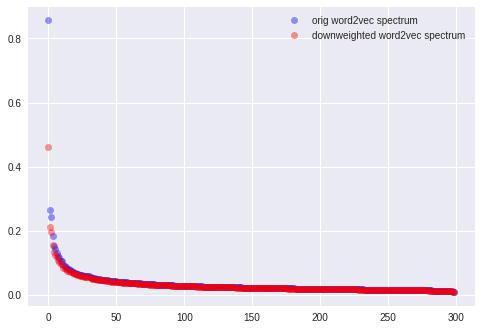

In [0]:
C_proto_word2vec = protoConceptor('word2vec', plotSpectrum = True)

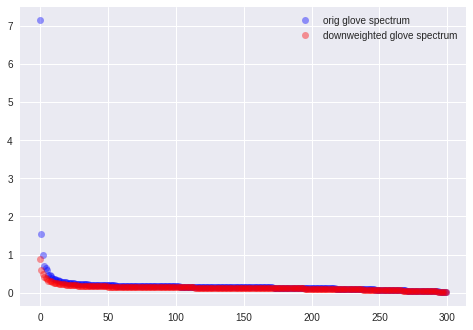

In [0]:
C_proto_glove = protoConceptor('glove', plotSpectrum = True)

# Evaluate 

The evaluation data set are collected by Manaal Faruqui at https://github.com/mfaruqui/eval-word-vectors/tree/master/data/word-sim


In [0]:
!git clone https://github.com/mfaruqui/eval-word-vectors

Cloning into 'eval-word-vectors'...
remote: Enumerating objects: 54, done.
remote: Total 54 (delta 0), reused 0 (delta 0), pack-reused 54
Unpacking objects: 100% (54/54), done.


In [0]:
dataSets = ['EN-RG-65.txt', 'EN-WS-353-ALL.txt', 'EN-RW-STANFORD.txt', 'EN-MEN-TR-3k.txt', 'EN-MTurk-287.txt', 'EN-SIMLEX-999.txt', 'EN-SimVerb-3500.txt']

 

def similarity_eval(dataSetAddress, wordVecModel_str, conceptorProj = False):
    wordVecModel = eval(wordVecModel_str)
    vocab = set(list(wordVecModel.vocab))
    
    fread_simlex = open(dataSetAddress, "r")
    
    pair_list = []

    line_number = 0
    for line in fread_simlex:
        if line_number > 0:
            tokens = line.split()
            word_i = tokens[0]
            word_j = tokens[1]
            score = float(tokens[2])
            if word_i in vocab and word_j in vocab:
                pair_list.append( ((word_i, word_j), score) )
        line_number += 1

    pair_list.sort(key=lambda x: - x[1]) # order the pairs from highest score (most similar) to lowest score (least similar)


    extracted_scores = {}

    extracted_list = []
    
    C = np.zeros((300, 300))
    
    if conceptorProj:
        C = Conceptors[wordVecModel_str]
               
    for (x,y) in pair_list:
        (word_i, word_j) = x
        
        current_distance = cosine( wordVecModel[word_i]  - C @ wordVecModel[word_i]  , wordVecModel[word_j] - C@ wordVecModel[word_j]    )        

        extracted_scores[(word_i, word_j)] = current_distance
        extracted_list.append(((word_i, word_j), current_distance))

    extracted_list.sort(key=lambda x: x[1])

    spearman_original_list = []
    spearman_target_list = []

    for position_1, (word_pair, score_1) in enumerate(pair_list):
        score_2 = extracted_scores[word_pair]
        position_2 = extracted_list.index((word_pair, score_2))
        spearman_original_list.append(position_1)
        spearman_target_list.append(position_2)

    spearman_rho = spearmanr(spearman_original_list, spearman_target_list)
    
    return spearman_rho[0]



In [0]:

def loadMuResult():
## (Optional) Load the results reported in https://openreview.net/pdf?id=HkuGJ3kCb
    w2v_mu_result = {}
    w2v_mu_result['EN-RG-65.txt'] = 0.7834
    w2v_mu_result['EN-WS-353-ALL.txt'] = 0.6905
    w2v_mu_result['EN-RW-STANFORD.txt'] = 0.5433
    w2v_mu_result['EN-MEN-TR-3k.txt'] = 0.7908
    w2v_mu_result['EN-MTurk-287.txt'] = 0.6935
    w2v_mu_result['EN-SIMLEX-999.txt'] = 0.4501
    w2v_mu_result['EN-SimVerb-3500.txt'] = 0.3650



    glove_mu_result = {}
    glove_mu_result['EN-RG-65.txt'] = 0.7436
    glove_mu_result['EN-WS-353-ALL.txt'] = 0.7679
    glove_mu_result['EN-RW-STANFORD.txt'] = 0.5204
    glove_mu_result['EN-MEN-TR-3k.txt'] = 0.8178
    glove_mu_result['EN-MTurk-287.txt'] = 0.7085
    glove_mu_result['EN-SIMLEX-999.txt'] = 0.4497
    glove_mu_result['EN-SimVerb-3500.txt'] = 0.3223
    
    return w2v_mu_result, glove_mu_result


w2v_mu_result, glove_mu_result = loadMuResult()

# Adjust the conceptor and display the quota

The quota around 10% seem to perform OK

In [0]:
Conceptors = {}
beta1 = 2 # claim more quota than 1
beta2 = 1 # no adjustment 


Conceptors['word2vec'] =  PHI(C_proto_word2vec, beta1)
Conceptors['glove'] =  PHI(C_proto_glove, beta2) # tune the aperture


print('Quota for word2vec conceptor is', trace(PHI(C_proto_word2vec, beta1))/300)
print('Quota for glove conceptor is', trace(PHI(C_proto_glove, beta2))/300)


Quota for word2vec conceptor is 0.10454383790028055
Quota for glove conceptor is 0.13167516954965094


In [0]:
print('beta1:', beta1, 'beta2:', beta2)

wordSimResult = {}


for dataset in dataSets:
    dataSetAddress = resourceFile + 'eval-word-vectors/data/word-sim/' + dataset
    print('evaluating the data set', dataset)
    
    
    print('Word2Vec + ABTT %.4f: ' % w2v_mu_result[dataset])
    
    
    print('Word2Vec + conceptor : %.4f' %  similarity_eval(dataSetAddress, 'word2vec', conceptorProj = True))

    print('Glove + ABTT %.4f: ' % glove_mu_result[dataset])

    
    print('GloVe + conceptor: %.4f'  % similarity_eval(dataSetAddress, 'glove', conceptorProj = True))
    
    wordSimResult['Word2Vec-'+dataset.split('.')[0]] = [ w2v_mu_result[dataset] * 100, round(similarity_eval(dataSetAddress, 'word2vec', conceptorProj = True) * 100, 2)]
    wordSimResult['GLOVE-'+dataset.split('.')[0]] = [glove_mu_result[dataset] * 100, round(similarity_eval(dataSetAddress, 'glove', conceptorProj = True) * 100, 2)]

        
    print('\n')

beta1: 2 beta2: 1
evaluating the data set EN-RG-65.txt
Word2Vec + ABTT 0.7834: 
Word2Vec + conceptor : -0.7892
Glove + ABTT 0.7436: 
GloVe + conceptor: -0.7667


evaluating the data set EN-WS-353-ALL.txt
Word2Vec + ABTT 0.6905: 
Word2Vec + conceptor : -0.6966
Glove + ABTT 0.7679: 
GloVe + conceptor: -0.7948


evaluating the data set EN-RW-STANFORD.txt
Word2Vec + ABTT 0.5433: 
Word2Vec + conceptor : -0.5521
Glove + ABTT 0.5204: 
GloVe + conceptor: -0.5382


evaluating the data set EN-MEN-TR-3k.txt
Word2Vec + ABTT 0.7908: 
Word2Vec + conceptor : -0.7867
Glove + ABTT 0.8178: 
GloVe + conceptor: -0.8316


evaluating the data set EN-MTurk-287.txt
Word2Vec + ABTT 0.6935: 
Word2Vec + conceptor : -0.6694
Glove + ABTT 0.7085: 
GloVe + conceptor: -0.7226


evaluating the data set EN-SIMLEX-999.txt
Word2Vec + ABTT 0.4501: 
Word2Vec + conceptor : -0.4678
Glove + ABTT 0.4497: 
GloVe + conceptor: -0.4651


evaluating the data set EN-SimVerb-3500.txt
Word2Vec + ABTT 0.3650: 
Word2Vec + conceptor : -0

In [0]:
import pandas as pd

wordSimResult_df = pd.DataFrame(wordSimResult, index = ['all-but-the-top', 'conceptor'] ).T

Text(0,0.5,'Pearson correlation coefficient x 100')

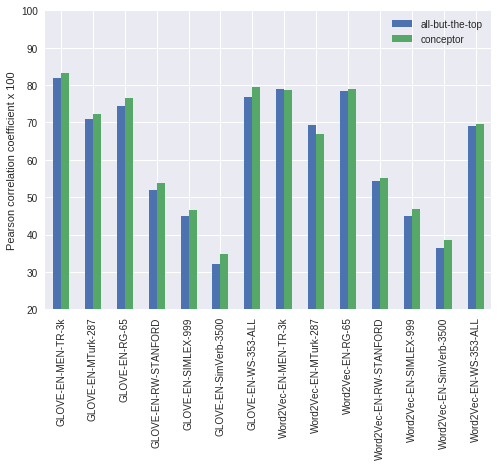

In [0]:
ax = wordSimResult_df.plot(kind="bar")
ax.legend(loc="best")
ax.set_ylim(20,100)
ax.set_ylabel("Pearson correlation coefficient x 100")
